# Auslesen und Zählen der Gegenstände im Grundriss

Das Ziel besteht darin, aus den Grundrissen (siehe unten) die enthaltenen Möbelstücke zu identifizieren und deren Anzahl zu ermitteln. Dazu wird der Grundriss im DXF-Format importiert, aus welchem die Metadaten ausgelesen werden. Um den Automatisierungsgrad künftig weiter zu steigern, könnte die API - Schnittstelle zu AutoCAD angebunden werden, die es ermöglicht, die Metadaten direkt pro Projekt auszulesen ohne einem zusätzlichen Dateiimport.

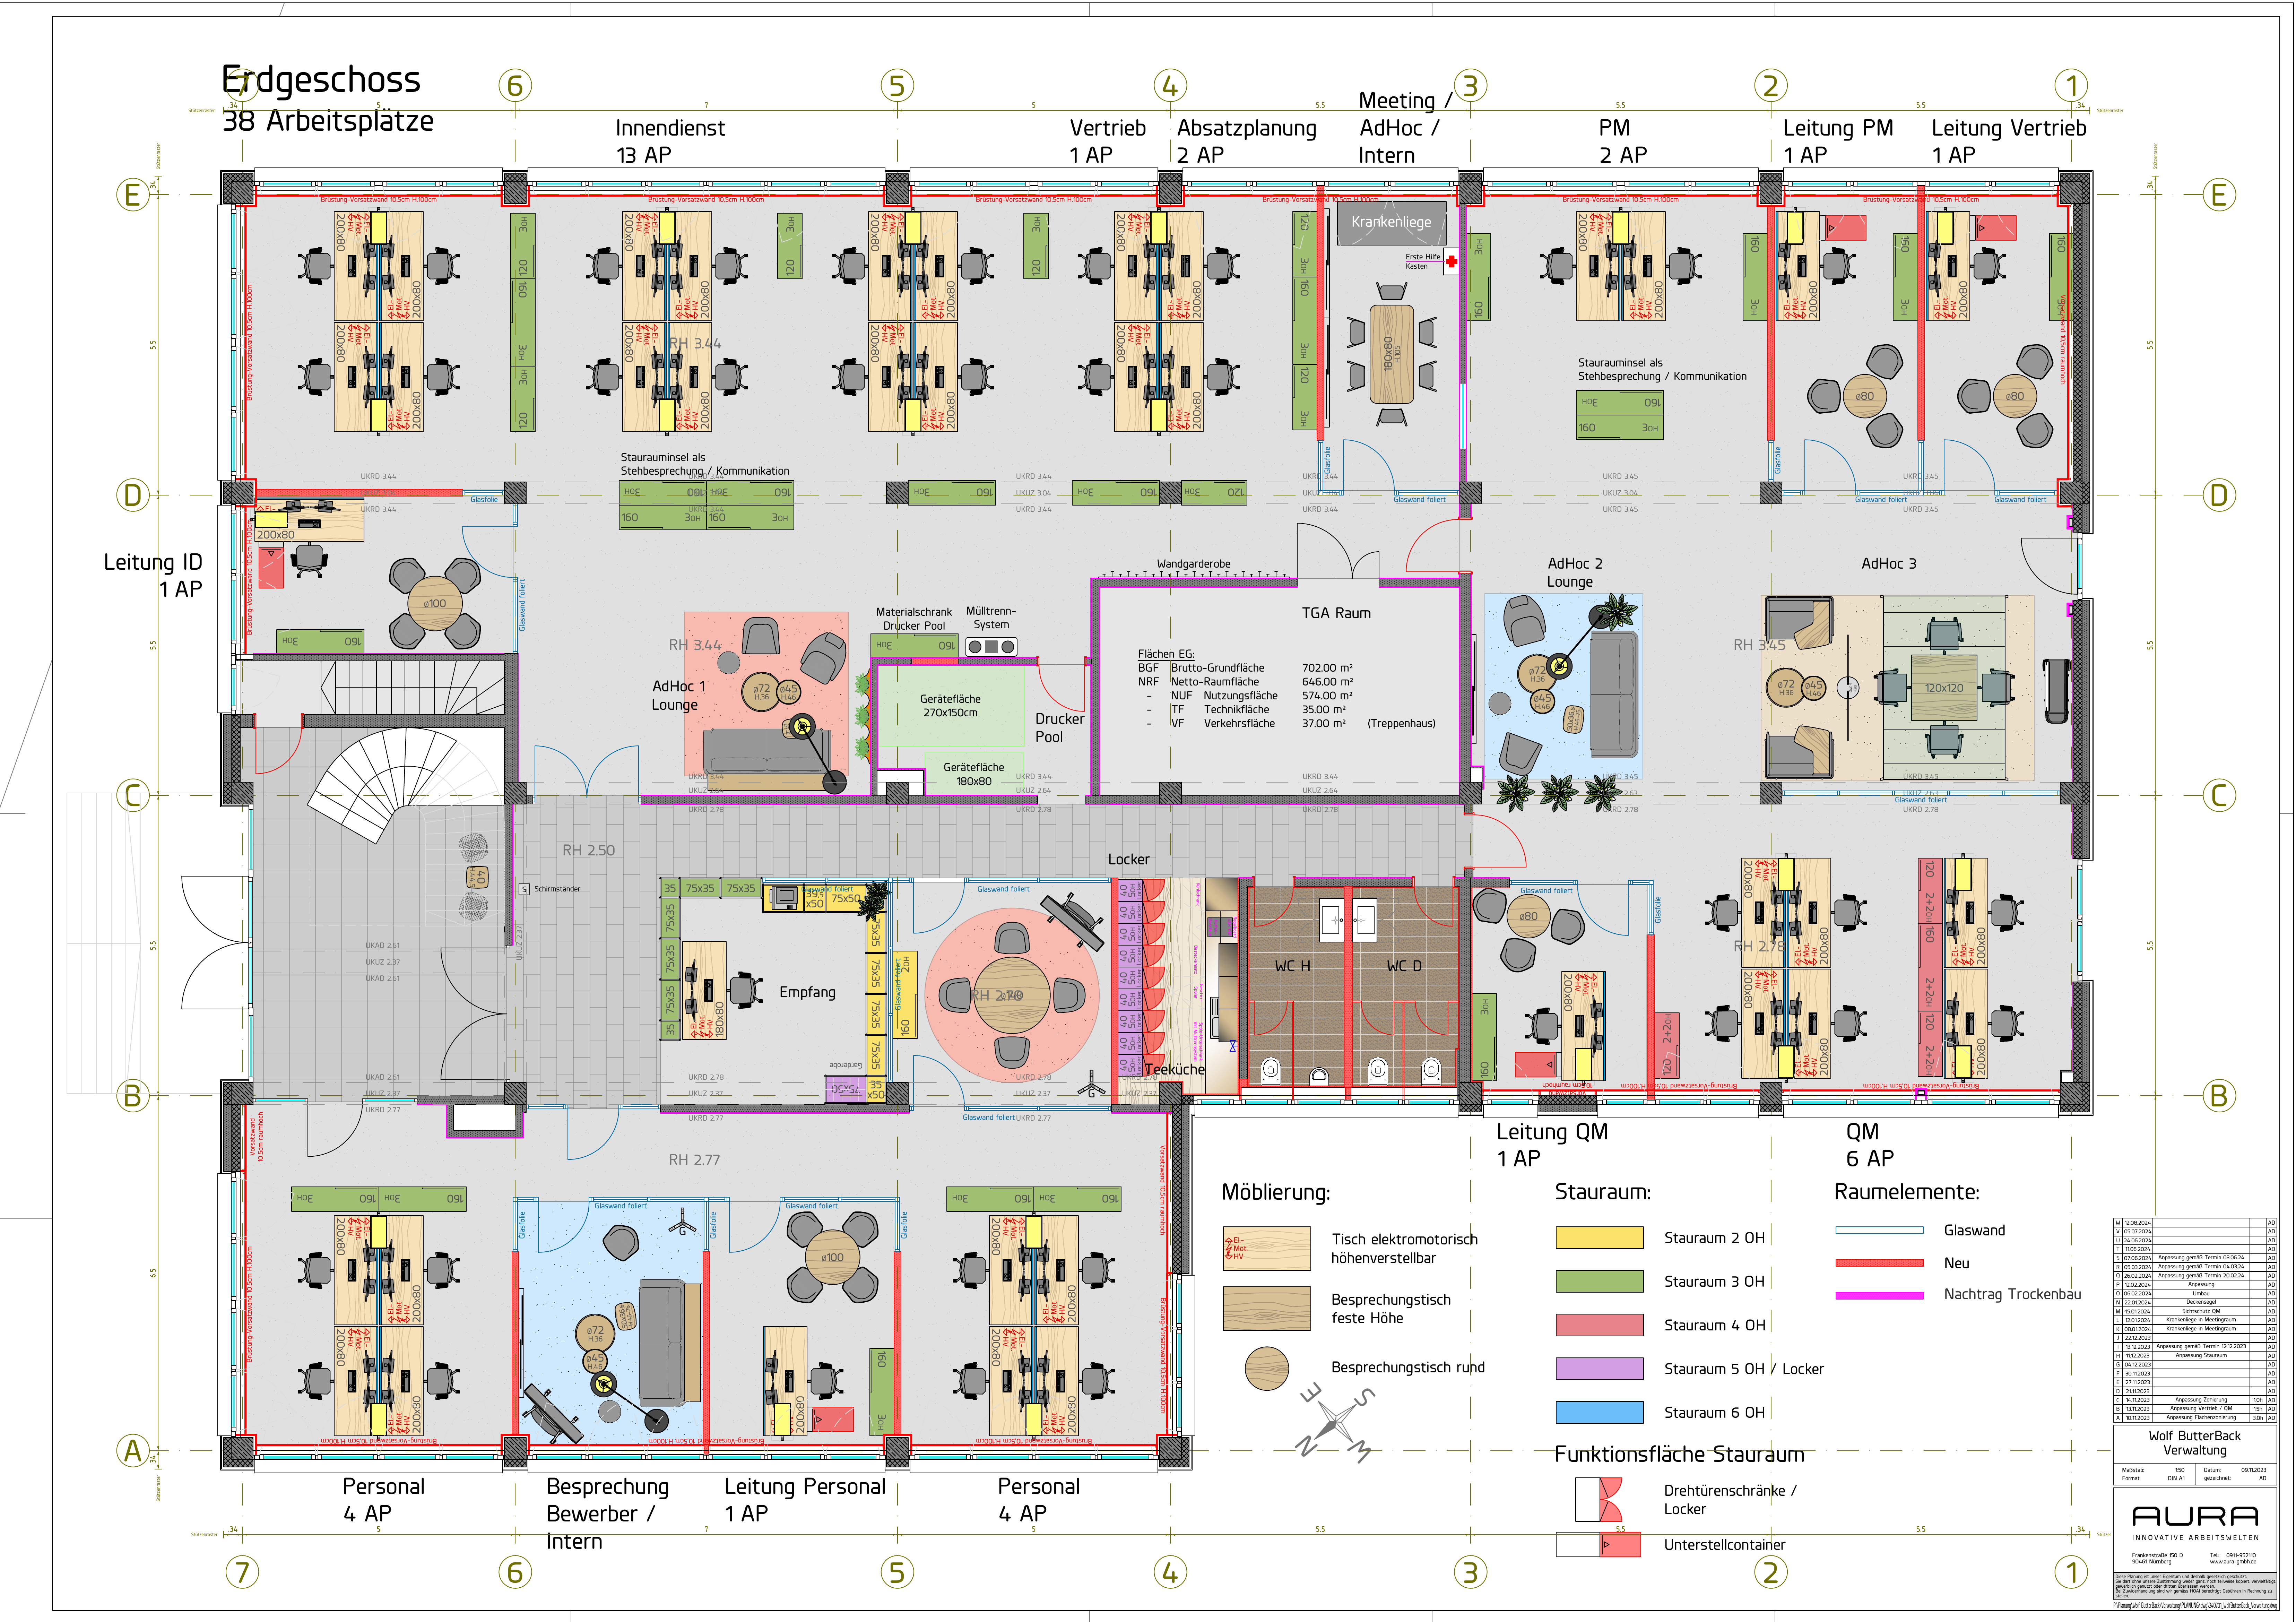

In [1]:
from PIL import Image
Image.open('floorplan.png')

In [2]:
# Imports
import ezdxf
import pandas as pd

### Laden des Grundrisses

In [3]:
# Öffne die DXF-Datei
dxf_file = 'floorplan.dxf'

# Lesen der Datei und Speichern in einer Variable
doc = ezdxf.readfile(dxf_file)

# Extraktion der Layouts
msp = doc.modelspace()

# Extraktion der Blocksections
#blocks = doc.blocks

### Extraktion der Blöcke und Layer

Das Fileformat enthält verschiedene Metadaten zu der Form, Farbe und Position der Objekte im Grundriss. Diese können über Methoden extrahiert werden.

Die Extraktion der Blöcke und ihrer zugehörigen Layer hat gezeigt, dass die Benennung der Blöcke zum großen Teil nicht sprechend ist. Das Bedeutet es müssen interne Standards zur Benennung der Blöcke (und auch Objekte) definiert werden.

In [4]:
# Erstellen einer Liste, die jeweils einen Blocknamen und Layer enthält
data = []

for entity in msp:
    layer = entity.dxf.layer
    if entity.dxftype() == 'INSERT':  # INSERT = Blockeinfügungen
        block_name = entity.dxf.name

        # Füge eine Zeile mit Blocknamen und Layer zur Liste hinzu
        data.append({'Blockname': block_name, 'Layer': layer})

# Erstelle DataFrame aus der Liste
df_blocks = pd.DataFrame(data)

# Ausgabe
print("Name der Blöcke mit zugeordnetem Layer:")
df_blocks

Name der Blöcke mit zugeordnetem Layer:


Blockname                 Layer
0                Klima-EG       A_KLima-Lüftung
1                 hfjhfjh               A_DECKE
2            cxcxcxcxvcvc               A_BODEN
3         jgjgjgjgjgjgjgj             _AU_MÖBEL
4                khgjhfff             _AU_MÖBEL
..                    ...                   ...
243  PintaBalance-300x125  A_Decke_AKUSTIKSEGEL
244  PintaBalance-300x125  A_Decke_AKUSTIKSEGEL
245  PintaBalance-300x125  A_Decke_AKUSTIKSEGEL
246  PintaBalance-300x125  A_Decke_AKUSTIKSEGEL
247  PintaBalance-300x125  A_Decke_AKUSTIKSEGEL

[248 rows x 2 columns]

### Anzahl der Blöcke pro Layer

Jedem Block ist ein Layer zugeordnet. Gruppiert man die Blöcke nach den Layern, zeigt sich, dass sich die meisten Objekte in der Ebene der "_AU_MÖBEL" sowie der "A_Decken_Akustiksegel" befinden. Es sind ebenfalls Objekte vorhanden, welche keinem Layer zugeordnet sind. Diese müsssen ggf. noch korrigiert werden.

In [5]:
# Gruppiere nach Layer und zähle die Anzahl der Blöcke pro Layer
layer_counts = df_blocks.groupby('Layer').size().reset_index(name='Block Count')

# Ausgabe des Ergebnisses
print("Name der Layer mit der Anzahl der enthaltenen Blöcke (Möbelstücke):")
layer_counts

Name der Layer mit der Anzahl der enthaltenen Blöcke (Möbelstücke):


Layer  Block Count
0                     0           12
1               A_BODEN            1
2           A_Bemassung            1
3      A_Boden_BEMAßUNG            1
4               A_DECKE            1
5  A_Decke_AKUSTIKSEGEL           42
6        A_GRUNDRISS-2D            1
7       A_KLima-Lüftung            1
8             _AU_MÖBEL          188

### Anzahl der Möbelstücke pro Block

Jeder Block ist ein Möbelstück. Die Blöcke müssen jedoch ebenfalls standartisiert benannt werden, um diese eindeutig zuordnen zu können. Es ist möglich die Ojekte gefiltert nach den Layern (nur den Layer "_AU_MÖBEL" zum beispiel) anzuzeigen oder alle Objekte aus allen Layern, falls die Decken- und Bodenlayer ebenfalls benötigt werden. 

In [6]:
# Filtere den DataFrame nach dem Layer "_AU_MÖBRL"
filtered_df = df_blocks[df_blocks['Layer'] == '_AU_MÖBEL']

# Gruppiere nach Blockname und zähle die Anzahl der Blöcke in diesem Layer
block_counts = filtered_df.groupby('Blockname').size().reset_index(name='Block Count')

# Sortiere die Ergebnisse absteigend nach 'Block Count'
block_counts = block_counts.sort_values(by='Block Count', ascending=False)

# Ausgabe des Ergebnisses
print("Anzahl der Möbelstücke im Grundriss (Nur vom Layer '_AU_MÖBEL'):")
block_counts


Anzahl der Möbelstücke im Grundriss (Nur vom Layer '_AU_MÖBEL'):


Blockname  Block Count
7                              AP-200-2           37
14  Lightnet_CUBIC F2_Side-Cut-Out-Base           22
43                           sts160-3oh           22
34                          locker40-5R            9
1                                  *U72            8
40                           sts120-3oh            7
17                              Pflanze            6
16                                Perch            6
0                                 *U262            5
37                              poknjpk            4
30                               kjnhkn            4
39                         sts120-2+2oh            3
36                                paddy            3
35                        nota-table-hv            3
47                              ztdgufc            3
13                            GS-plant1            3
4                           A$C62901F8B            3
15                        MS-SurfaceHub            2
8                  Alcove_Highback_Work            2
5                           A$C7ec8e4b4            2
29                               kjlkjn            2
9                         ArmChair_grün            2
21                          fghjfjhjhgf            2
19                                 bend            2
18                 Vitra_Wire Chair DKR            2
12                       Flex-Trennwand            2
45                       teamwagenmitWB            1
44                           suite3er-2            1
2                                  *U73            1
41                         sts160-2+2oh            1
3                           A$C1E7610B2            1
46        vitra_Metal Side Table_mittel            1
38                                rdcgv            1
6                              AP-180-2            1
42                           sts160-2oh            1
31                              kücheEG            1
33                            lkjkjfkhg            1
32                         ljhgjhgfdhgf            1
10                            BTrund140            1
28                           kjhbjhckhj            1
27                             khgjhfff            1
26                            khgfjgdjh            1
25                       khgfhgfgfeshfd            1
11                             Ditsch3a            1
23                       jhbjhbhbhhgvgv            1
22                      jgjgjgjgjgjgjgj            1
20                            bt120x120            1
24                          jhjhfhgdhgg            1

### Auslesen der Texte im Grundriss

Die Grundrisse enthalten nicht nur geometische Formen (Blöcke) sondern auch Texte, welche zusätzliche Informationen zu den Möbelstücken und Modulen liefern (beispielsweise Längen- und Breitenangaben). Um diese zu extrahieren kann ebenfalls eine Methode verwendet werden. Für die weitere Analyse könnte eine Schleife geschrieben werden, welche über die extrahierte Blocks loopt und die enthaltenen Textblöcke ausliest. Auf diese Weise lassen sich die Inhalte den Möbelstücken zuordnen.

In [7]:
# Iteriere über alle Entitäten im Model-Space
for text in doc.entitydb.query("TEXT"):
    print(f"Beispiel für Textangabe aus dem Grundriss: {text.dxf.text}")
    break

Beispiel für Textangabe aus dem Grundriss: 160 m


### Auslesen der Positionsdaten

Die Metadaten enthalten nicht nur die Blocknamen, sondern darüber hinaus weitere Informationen wie die Position oder maße des Möbelstücks. Diese Infromationen werden für die Erstellung der Ausschreibungen nicht benötigt, bieten aber Potzenziale für das Training eines Maschine Learning Algorithmus zur automatischen Erstellung von Grundrissen und der möglichen Anordnung von Möbelstücken in einem Raum.

In [8]:
# Iteriere über alle Entitäten im Model-Space
for entity in msp:
    if entity.dxftype() == 'INSERT':  # INSERT steht für Blockeinfügungen
        block_name = entity.dxf.name
        print(f"Gefundener Block: {block_name} an Position {entity.dxf.insert}")
        break

Gefundener Block: Klima-EG an Position (26.81833664754364, 47.09750491698033, 0.0)
